<a href="https://colab.research.google.com/github/DavidJimenez10/Introduccion_Inteligencia_Artificial/blob/main/Algoritmo_Genetico_Viajero_Vendedor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema del viajero vendedor (Travelling Salesman Problem)

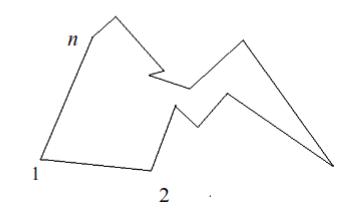

Hallar el camino que visita N ciudades sólo una vez. Para simplificar el problema se supondra las N ciudades como adyacentes

* Problema NP
* Hay n! soluciones que explorar
* No existe un algoritmo eficiente para hallar la solución

Parametrización:

A1= [0,1,2,3,4,0]

premio: dist = d(0,1) + d(1,2) + ... + d(4,0)

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd

In [ ]:
class Genetic_Algorithm (ABC):
  """Clase generica algoritmo genetico

  Atributos:
    size_population(int): Tamaño de la poblacion
    generations(int): Numero generaciones
    mutation_probability(float): Probablidad mutacion, entre [0,1]
    crossover_probability(float): Probablidad cruce, entre [0,1]

  Metodos:
    fitness_funct: Funcion abstracta, retorna puntaje de calidad cromosoma
    valid: retorna verdadero si el cromosoma es valido
    generate_first_population: Metodo abstracto, devuelve la primera poblacion de la simulacion
    roulette: Devuelve la probabilidad acumulada para cada cromosoma de la poblacion
    selection: Devuelve un cromosoma dada una probabilidad
    crossover: Metodo abstracto, devuelve dos cromosomas hijos
    mutate: Metodo abstracto, devuelve un cromosoma mutado
  """
  def __init__(self, size_individual, size_population = 100, generations = 400, mutation_probability = 0.1, crossover_probability = 0.9):
    self.size_individual = size_individual
    self.size_population = size_population
    self.generations = generations
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability

  @abstractmethod
  def fitness_funct(self,x):
    pass

  def valid(self, x):
   return True

  @abstractmethod
  def generate_first_population(self):
    pass

  def roulette(self,population):
    """Metodo de seleccion ruleta
    Parametro:
      population(list): poblacion 
    """
    of = [self.fitness_funct(s) for s in population]
    probability = of/sum(of)
    accumulatedProb = np.cumsum(probability)
    return accumulatedProb 

  def selection(self, population, accumulatedProb):
    """
    Parametros:
      population(list) : Poblacion
      accumulatedProb(array) : Probabilidad acumulada 
    """
    nr = np.random.uniform()
    for i,p in enumerate(accumulatedProb):
      if nr<p:
        return population[i]

  @abstractmethod
  def crossover(self,ind1, ind2):
    pass

  @abstractmethod
  def mutate(self,ind):
    pass


  def genetic_algorithm(self):

    population = self.generate_first_population() #Primera generacion

    accumulatedProb = self.roulette(population)
    
    self.bestIndividual = [population[0]] # Lista de mejores individuos de cada población
    
    #Ciclo para simular todas las generaciones
    for i in range(self.generations):
      #Generar la nueva población
      nextPopulation = []
      count = 0

      while True: #Termina cuando tengamos NP individuos
        
        #Hacemos selección de dos individuos
        ind1 = self.selection(population, accumulatedProb)
        ind2 = self.selection(population, accumulatedProb)
        #Probabilidad de cruce
        crossProb = nr = np.random.uniform()
        
        if crossProb<self.crossover_probability:
          #Genero dos hijos
          child1,child2 = self.crossover(ind1,ind2)
          #Validacion hijos
          if self.valid(child1):
            nextPopulation.append(child1)
          if self.valid(child2):
            nextPopulation.append(child2)
        else:
          nextPopulation.append(ind1)
          nextPopulation.append(ind2)

        # Hacemos selección de un individuo
        ind = self.selection(population, accumulatedProb)
        #Probabilidad mutacion
        mutProb = nr = np.random.uniform()

        if mutProb<self.mutation_probability:
          #Mutacion individuo
          child = self.mutate(ind)
          #Validacion mutacion
          if self.valid(child):
            nextPopulation.append(child)
        else:
          nextPopulation.append(ind)

        #Validacion tamaño de la poblacion
        if len(nextPopulation) >= self.size_population:
          nextPopulation = nextPopulation[0:self.size_population]
          break;
      #Ordenando mejores cromosomas de la poblacion
      accumulatedProb = self.roulette(nextPopulation)
      sorted_population = sorted(nextPopulation,key = self.fitness_funct,reverse = True)
      #Guardando mejor cromosoma
      self.bestIndividual.append(sorted_population[0])
      
      population = nextPopulation

    #Retorno mejor cromosoma y su funcion de calidad
    sortedBest = sorted(self.bestIndividual,key = self.fitness_funct,reverse = True)
    return sortedBest[0],self.fitness_funct(sortedBest[0])

In [ ]:
class GA_RouteCities(Genetic_Algorithm):
  """Clase del problema de las ciudades
  Atributos:
    target(int): ciudad objetivo, es decir la primer y ultima ciudad
    list_cities(array): array de las N ciudades
    distances(array): array cuadrado NxN contiene las distacias entre las diferentes ciudades 
  """

  def __init__(self, target, max_distance, min_distance, size_individual, size_population, generations, mutation_probability, crossover_probability):
    """
    Parametros:
      target(int): ciudad objetivo, es decir la primer y ultima ciudad
      max_distance(float): Distancia minima entre ciudades [km]
      min_distance(float): Distancia maxima entre ciudade [km]
    """
    super(GA_RouteCities, self).__init__(size_individual, size_population, generations, mutation_probability, crossover_probability)
    
    self.target = target
    
    self.list_cities = np.arange(self.size_individual)
    
    #La distancia entre las ciudades es un array cuadrado simetrico
    length = (max_distance-min_distance)*np.random.random_sample((self.size_individual,self.size_individual))+min_distance
    length_cities_symm = (length + length.T)/2 #Haciendo array simetrico
    np.fill_diagonal(length_cities_symm, 0) #Diagonal de 0's

    self.distances = length_cities_symm



  def generate_first_population(self):
    #Hago una copia de la lista de ciudades y elimino la ciudad target
    cities_but_target = np.copy(self.list_cities)
    cities_but_target = np.delete(cities_but_target, np.where(cities_but_target == self.target))
    
    population=[]

    count=0;

    while True:
      #"Barajo" las ciudades
      np.random.shuffle(cities_but_target)
      ind = np.copy(cities_but_target)
      #Inserto la ciudad objetivo al inicio y al final
      ind = np.insert(ind,0,self.target)
      ind = np.append(ind,self.target)
      
      #Valido el cromosoma
      if (self.valid(ind)):
        population.append(ind)
        count=count+1

      #Valido haber completado toda la poblacion
      if count== self.size_population:
        return population

  def fitness_funct(self,individuo):
    index_actual = 1
    suma_distancias = 0

    #Recorro la lista de ciudades, sumando la distacia de cada par de ciudades
    while index_actual < individuo.size:
      suma_distancias += self.distances[individuo[index_actual-1],individuo[index_actual]]
      index_actual += 1

    return 1/suma_distancias

  def crossover(self,ind1, ind2):
    #Hago una copia del primer individuo
    cross_ind_1 = np.copy(ind1)
    cross_ind_1 = np.delete(cross_ind_1, np.where(cross_ind_1 == self.target))
    
    #Hago una copia del segundo individuo
    cross_ind_2 = np.copy(ind2)
    cross_ind_2 = np.delete(cross_ind_2, np.where(cross_ind_2 == self.target))
    
    #Genero punto de corte
    cp=np.random.randint(1,len(cross_ind_1))

    #Genero los hijos
    child1 = np.concatenate((cross_ind_1[:cp],cross_ind_2[np.in1d(cross_ind_2,cross_ind_1[:cp], invert=True)]), axis=None)
    child2 = np.concatenate((cross_ind_2[:cp],cross_ind_1[np.in1d(cross_ind_1,cross_ind_2[:cp], invert=True)]), axis=None)
    
    #Inserto la ciudad objetivo al inicio y al final
    child1 = np.insert(child1, 0,self.target)
    child1 = np.append(child1, self.target)

    #Inserto la ciudad objetivo al inicio y al final
    child2 = np.insert(child2,0,self.target)
    child2 = np.append(child2,self.target)

    return child1,child2

  def mutate(self,ind):
    #Hago una copia del individuo
    mutate_ind = np.copy(ind)
    #Elimino la ciudad objetivo
    mutate_ind = np.delete(mutate_ind, np.where(mutate_ind == self.target))

    #Genero las dos posiciones a cambiar
    cp1=np.random.randint(0,len(mutate_ind))
    cp2=np.random.randint(0,len(mutate_ind))

    #Reasigno los valores de las posiciones utilizando tuple unpacking
    mutate_ind[cp1], mutate_ind[cp2] = mutate_ind[cp2], mutate_ind[cp1] 

    #Inserto la ciudad objetivo al inicio y al final
    mutate_ind = np.insert(mutate_ind,0,self.target)
    mutate_ind = np.append(mutate_ind, self.target)

    return mutate_ind

  def display(self):
    print(pd.DataFrame(self.distances))


In [ ]:
#@Ejecutar el problema de la mochila con los parámetros seleccionados
num_ciudades =  10#@param {type:"integer"}
init_city =  2#@param {type:"number"}
min_distance_km = 3 #@param {type:"number"}
max_distance_km = 100 #@param {type:"number"}


sizePopulation = 30 #@param {type:"integer"}
generations =  300#@param {type:"integer"}
mutation_probability = 0.2 #@param {type:"number"}
crossover_probability = 0.9 #@param {type:"number"}


from IPython.display import Markdown, display
title='Suponiendo un problema donde tenemos N ciudades, como debo debo visitar todas las ciudades, utilizando el trayecto mas corto sin repetir ciudad y volviendo a la ciudad inicial'
display(Markdown('**{}**'.format(title)))
display(Markdown("**Las siguientes ciudades:**"))
print(['ciudad '+str(i) for i in range(num_ciudades)])
KP=GA_RouteCities(init_city, min_distance_km, max_distance_km,num_ciudades, sizePopulation, generations, mutation_probability, crossover_probability)
solution, f=KP.genetic_algorithm()
resp='La distancia de la mejor solucion es : ' +'{:.4f}'.format(1/f)
display(Markdown('**{}**'.format(resp)))
display(Markdown("**La mejor combinación es recorrer las ciudades:**"))
print(['ciudad '+str(s) for s in solution])
KP.display()
#display(Markdown(KP))

**Suponiendo un problema donde tenemos N ciudades, como debo debo visitar todas las ciudades, utilizando el trayecto mas corto sin repetir ciudad y volviendo a la ciudad inicial**

**Las siguientes ciudades:**

['ciudad 0', 'ciudad 1', 'ciudad 2', 'ciudad 3', 'ciudad 4', 'ciudad 5', 'ciudad 6', 'ciudad 7', 'ciudad 8', 'ciudad 9']


**La distancia de la mejor solucion es : 310.2843**

**La mejor combinación es recorrer las ciudades:**

['ciudad 2', 'ciudad 7', 'ciudad 5', 'ciudad 3', 'ciudad 6', 'ciudad 1', 'ciudad 9', 'ciudad 8', 'ciudad 4', 'ciudad 0', 'ciudad 2']
           0          1          2          3          4          5  \
0   0.000000  38.326423  14.423158  41.484447  13.556896  66.759150   
1  38.326423   0.000000  53.612983  40.030904  44.649148  50.010421   
2  14.423158  53.612983   0.000000  41.738750  44.898599  44.720278   
3  41.484447  40.030904  41.738750   0.000000  72.487796  34.632214   
4  13.556896  44.649148  44.898599  72.487796   0.000000  75.868384   
5  66.759150  50.010421  44.720278  34.632214  75.868384   0.000000   
6  47.381512  53.777195  33.848837  28.290851  71.291251  62.104010   
7  41.610658  56.797090  16.621398  57.710167  29.450265  37.241997   
8  32.042323  27.361419  53.852022  77.811588  41.578482  56.942340   
9  59.896378  48.685755  55.545585  32.239400  53.888821  61.678768   

           6          7          8          9  
0  47.381512  41.610658  32.042323  5